In [52]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [63]:
df = pd.read_csv("../results/data.csv")
index_new_exps = 4294
df = df.iloc[index_new_exps:]

df_newcol = df.set_axis(
    [
        "dataset",
        "foundational_model",
        "adapter",
        "n_features",
        "n_components",
        "is_fine_tuned",
        "pca_in_preprocessing",
        "use_revin",
        "context_length",
        "forecasting_horizon",
        "running_time",
        "seed",
        "metric",
        "value",
    ],
    axis=1,
)
df_newcol

df_newcol.to_csv("../results/data_clean.csv", index=False)

In [64]:
df = pd.read_csv("../results/data_clean.csv")
df["adapter"] = df["adapter"].fillna("no_adapter")
df.head()

,dataset,foundational_model,adapter,n_features,n_components,is_fine_tuned,pca_in_preprocessing,use_revin,context_length,forecasting_horizon,running_time,seed,metric,value
0,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,supervised,True,True,512.0,24,43.917139,20823.0,scaled_mse,3.927081
1,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,supervised,True,True,512.0,24,43.917139,20823.0,scaled_mae,1.039715
2,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,supervised,False,True,512.0,24,81.507269,26349.0,mse,4.060461
3,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,supervised,False,True,512.0,24,81.507269,26349.0,mae,1.466816
4,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,supervised,False,True,512.0,24,81.507269,26349.0,scaled_mse,4.010434


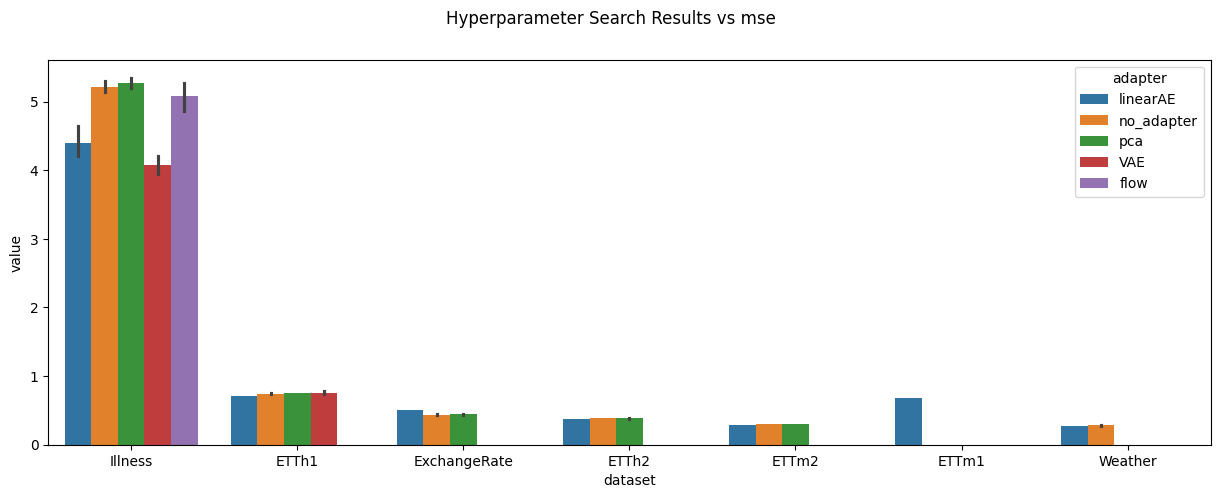

In [65]:
metric = "mse"

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
# axes = axes.flatten()
fig.suptitle(f"Hyperparameter Search Results vs {metric}")

sns.barplot(
    df.loc[df["metric"] == metric], x="dataset", y="value", hue="adapter", ax=axes
)
plt.show()

In [66]:
df.columns

Index(['dataset', 'foundational_model', 'adapter', 'n_features',
       'n_components', 'is_fine_tuned', 'pca_in_preprocessing', 'use_revin',
       'context_length', 'forecasting_horizon', 'running_time', 'seed',
       'metric', 'value'],
      dtype='object')

In [67]:
def print_scores(
    dataset,
    adapter,
    forecasting_horizon, 
    n_components,
    use_revin,
    pca_in_preprocessing,
    metric,
):
    df_ = df.loc[
        (df["dataset"] == dataset)
        & (df["adapter"] == adapter)
        & (df["n_components"] == n_components)
        & (df["use_revin"] == use_revin)
        & (df["pca_in_preprocessing"] == pca_in_preprocessing)
        & (df["metric"] == metric)
        & (df["forecasting_horizon"] == forecasting_horizon)
    ]
    print(
        f"Dataset: {dataset}, Adapter: {adapter}, n_components: {n_components}, use_revin: {use_revin}, pca_in_preprocessing: {pca_in_preprocessing}"
    )
    print(
        f"Mean: {df_['value'].mean()}, Std: {df_['value'].std()}, Standard Error: {df_['value'].sem()}"
    )
    print(f"Min: {df_['value'].min()}, Max: {df_['value'].max()}")
    print(
        f"25th percentile: {df_['value'].quantile(0.25)}, 75th percentile: {df_['value'].quantile(0.75)}"
    )
    print(f"Median: {df_['value'].median()}")
    print("Count of seeds: ", len(df_))
    print("\n")

In [68]:
dataset = "Illness"
adapter = "linearAE"
n_components = 7
use_revin = False
pca_in_preprocessing = False
metric = "mse"
forecasting_horizon = 24

print_scores(
    dataset,
    adapter,
    forecasting_horizon,
    n_components,
    use_revin,
    pca_in_preprocessing,
    metric,
)

Dataset: Illness, Adapter: linearAE, n_components: 7, use_revin: False, pca_in_preprocessing: False
Mean: 5.694898858085631, Std: 1.1758100566474103, Standard Error: 0.5258382430582976
Min: 4.590881187778505, Max: 7.243613899279165
25th percentile: 4.593984815510995, 75th percentile: 6.515664261698222
Median: 5.530350126161271
Count of seeds:  5


